# Diffusion resampling example

In this notebook we will see how to perform diffusion resampling for a Gaussian mixture model.
Define a model
$$
\begin{equation}
    \begin{split}
        \phi(x) &= \sum_{i=1}^c \omega_i \, \mathrm{N}(x; m_i, v_i), \\
        p(y \mid x) &= \mathrm{N}(y; H \, x, \Xi),
    \end{split}
\end{equation}
$$
and we wish to sample from $\pi(x) \propto \phi(x) \, p(y \mid x)$. Since the likelihood is linear Gaussian, we can draw samples exactly, and we will compare these exact samples to importance resampling.

Import necessary packages.

In [74]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from diffres.resampling import diffusion_resampling, ensemble_ot, multinomial
from diffres.tools import sampling_gm, gm_lin_posterior
from functools import partial

jax.config.update("jax_enable_x64", True)
key = jax.random.PRNGKey(666)

Next we generate 1) exact samples, and 2) importance samples with the prior as the proposal.

In [75]:
# Randomly generate the Gaussian mixture components
nsamples = 1024
c = 5  # GM components
d = 10  # x dimension
dy = 2  # y dimension
gm_weights = jnp.ones(c) / c  # mixture weights
ms = jax.random.uniform(key, minval=-5, maxval=5., shape=(c, d))
key, _ = jax.random.split(key)
_covs = jax.random.normal(key, shape=(c, d))
covs = jnp.einsum('...i,...j->...ij', _covs, _covs) + jnp.eye(d) * 1.
# eigvals, eigvecs = jnp.linalg.eigh(covs)  # this may not be platform invariant

sampler_gm = jax.jit(jax.vmap(sampling_gm, in_axes=[0, None, None, None, None, None]))
key, _ = jax.random.split(key)
keys = jax.random.split(key, nsamples)

# Samples from the Gaussian mixture prior
prior_samples = sampler_gm(keys, gm_weights, ms, _, _, covs)

# Compute and sample from the true posterior
key, _ = jax.random.split(key)
keys = jax.random.split(key, nsamples)
obs_op = jnp.ones((dy, d))
obs_cov = jnp.eye(dy)
y = jnp.einsum('ij,kj,k->i', obs_op, ms, gm_weights)
post_vs, post_ms, post_covs = gm_lin_posterior(y, obs_op, obs_cov, gm_weights, ms, covs)
# post_eigvals, post_eigvecs = jnp.linalg.eigh(post_covs)
true_post_samples = sampler_gm(keys, post_vs, post_ms, _, _, post_covs)


# Importance sampling using the prior samples as the proposal
@partial(jax.vmap, in_axes=[0])
def logpdf_likelihood(x):
    return jnp.sum(jax.scipy.stats.norm.logpdf(y, obs_op @ x, jnp.diag(obs_cov) ** 0.5))


log_ws = logpdf_likelihood(prior_samples)
log_ws = log_ws - jax.scipy.special.logsumexp(log_ws)
ws = jnp.exp(log_ws)

Now we have weighted samples `prior_samples, ws`.
We can then apply the resampling method to flatten the weights to obtain the approximate posterior samples.
Let us compare to the OT and multinomial approaches.

In [98]:
# Resampling starts
key, _ = jax.random.split(key)

# Diffusion resampling coefficients
a = -2
T = 1.
nsteps = 32
ts = jnp.linspace(0., T, nsteps + 1)
integrator = 'jentzen_and_kloeden'
ode = True

_, approx_post_samples = diffusion_resampling(key, log_ws, prior_samples, a, ts,
                                              integrator=integrator, ode=ode)
_, approx_post_samples_ot = ensemble_ot(key, log_ws, prior_samples, eps=0.3)
_, approx_post_samples_multinomial = multinomial(key, log_ws, prior_samples)

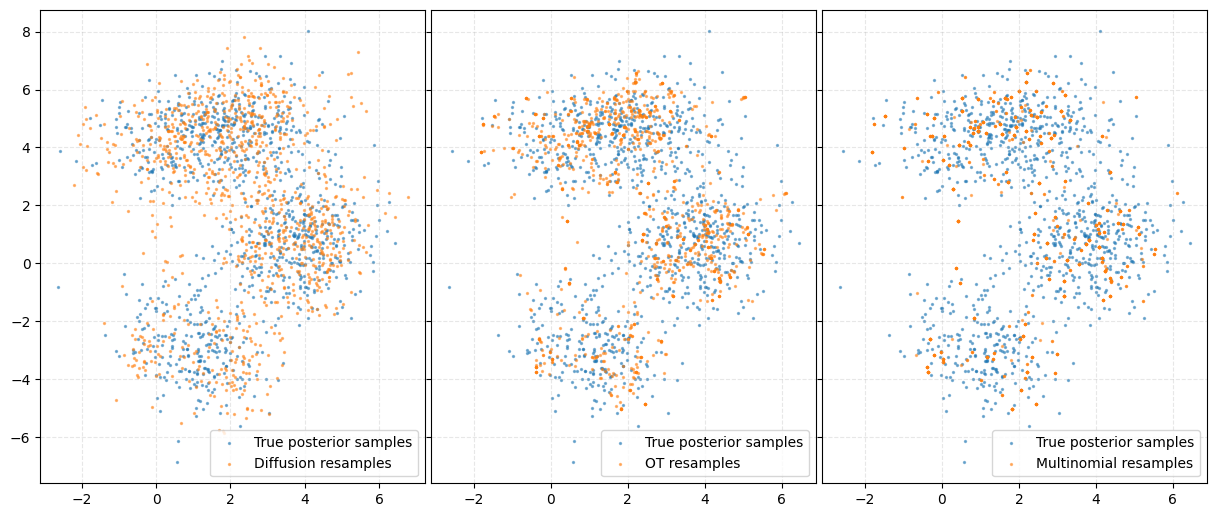

In [99]:
fig, axes = plt.subplots(figsize=(12, 5), ncols=3, sharey=True)
for ax in axes:
    _ = ax.scatter(true_post_samples[:, 0], true_post_samples[:, 1], s=2, alpha=.5, label='True posterior samples')

_ = axes[0].scatter(approx_post_samples[:, 0], approx_post_samples[:, 1], s=2, alpha=.5, label='Diffusion resamples')
_ = axes[1].scatter(approx_post_samples_ot[:, 0], approx_post_samples_ot[:, 1], s=2, alpha=.5, label='OT resamples')
_ = axes[2].scatter(approx_post_samples_multinomial[:, 0], approx_post_samples_multinomial[:, 1], s=2, alpha=.5, label='Multinomial resamples')

for ax in axes:
    ax.legend()
    ax.grid(linestyle='--', alpha=0.3, which='both')

plt.tight_layout(pad=.1)

Although we are not explicitly showing here, the resampling function are instantly differentiable.
Try `jax.grad` in any cases.